In [45]:
# %pip install nbformat

In [46]:
import nbformat

# Read your notebook (assuming version 4 for example purposes)
nb = nbformat.read("ml_project.ipynb", as_version=4)

# Normalize the notebook to add missing id fields and other updates
nbformat.validator.validate(nb)

# Write the normalized notebook back to a file
nbformat.write(nb, "ml_project_normalized.ipynb")

In [47]:
%run ml_project_normalized.ipynb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
dropped columns
cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned color
cleaned breed
dropped columns


/tmp/ipykernel_894108/1199118304.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_series = pd.to_datetime(df['intake_time'], errors='coerce')


cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned color
cleaned breed
Done running ml_project.ipynb.


In [48]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

In [49]:
# Trying to figure out SMOTE
from imblearn.over_sampling import SMOTE, SMOTENC
#df_train_downsample.head()

In [50]:
df_train.head()#['breed'].value_counts()

,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,intake_year,intake_month,intake_hour,primary_color,is_mix,size,outcome_type
0,Stray,Normal / Behavior,Dog,Spayed Female,96.0,2,2015,7,12,white,0,3,Return to Owner
1,Stray,Normal / Behavior,Dog,Intact Male,11.0,7,2016,4,18,sable,1,2,Return to Owner
2,Public Assist,Normal / Behavior,Cat,Neutered Male,24.0,Common,2022,5,0,orange,0,2,Transfer
3,Owner Surrender,Normal / Behavior,Dog,Neutered Male,24.0,2,2017,2,12,chocolate,1,4,Return to Owner
4,Public Assist,Normal / Behavior,Dog,Neutered Male,72.0,3,2019,4,9,black,1,5,Return to Owner


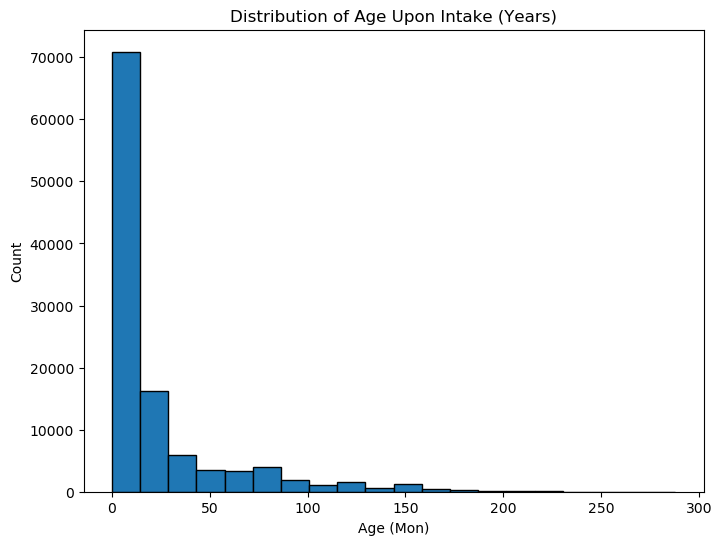

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(df_train['age_upon_intake'].dropna(), bins=20, edgecolor='black')
plt.title("Distribution of Age Upon Intake (Years)")
plt.xlabel("Age (Mon)")
plt.ylabel("Count")

plt.show()

In [52]:
age_bins = [0, 3, 6, 12, 24, 36, 60, 96, 144, 192, 300]  # now 11 bin edges → 10 bins
age_labels = [
    '0–3 mo',    # baby
    '3–6 mo',    # older baby
    '6–12 mo',   # adolescent
    '1–2 yr',    # young adult
    '2–3 yr',    
    '3–5 yr',    
    '5–8 yr',    
    '8–12 yr',   
    '12–16 yr',  
    '16–25 yr'   # older adult, extends to 25 yrs max
]

df_train['age_group'] = pd.cut(df_train['age_upon_intake'], bins=age_bins, labels=age_labels, right=False)
df_train['age_group'].value_counts()

age_group
0–3 mo      37772
2–3 yr      16192
1–2 yr      15782
3–5 yr       9351
3–6 mo       9281
6–12 mo      8056
5–8 yr       7357
8–12 yr      5073
12–16 yr     1979
16–25 yr      312
Name: count, dtype: int64

In [53]:
import pandas as pd
import numpy as np

def parse_feature_probs(nb_model, onehot_encoder, exclude_keywords=None):
    """
    Returns a cleaned DataFrame of feature probabilities from a fitted Naive Bayes model.

    Parameters:
    - nb_model: Fitted Naive Bayes model (e.g., CategoricalNB or MultinomialNB)
    - onehot_encoder: Fitted OneHotEncoder
    - exclude_keywords: List of substrings to exclude from the feature names (optional)

    Returns:
    - Cleaned Pandas DataFrame with features as rows and classes as columns
    """
    # Convert log probs to probabilities
    feature_probs = np.exp(nb_model.feature_log_prob_)  # shape: (n_classes, n_features)
    
    # Get feature names after one-hot encoding
    feature_names = onehot_encoder.get_feature_names_out()
    
    # Build DataFrame: rows = features, columns = classes
    feature_prob_df = pd.DataFrame(feature_probs.T, index=feature_names, columns=nb_model.classes_)
    
    # Filter out features by keywords
    if exclude_keywords:
        for keyword in exclude_keywords:
            feature_prob_df = feature_prob_df[~feature_prob_df.index.str.contains(keyword, case=False)]
    
    return feature_prob_df


In [54]:
df_train = bucket_seasons(df_train)
df_train = df_train.drop(columns='intake_month')


In [55]:
df_train.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,intake_year,intake_hour,primary_color,is_mix,size,outcome_type,age_group,season
0,Stray,Normal / Behavior,Dog,Spayed Female,96.0,2,2015,12,white,0,3,Return to Owner,8–12 yr,Summer
1,Stray,Normal / Behavior,Dog,Intact Male,11.0,7,2016,18,sable,1,2,Return to Owner,6–12 mo,Spring
2,Public Assist,Normal / Behavior,Cat,Neutered Male,24.0,Common,2022,0,orange,0,2,Transfer,2–3 yr,Spring
3,Owner Surrender,Normal / Behavior,Dog,Neutered Male,24.0,2,2017,12,chocolate,1,4,Return to Owner,2–3 yr,Winter
4,Public Assist,Normal / Behavior,Dog,Neutered Male,72.0,3,2019,9,black,1,5,Return to Owner,5–8 yr,Spring


In [56]:
# Convert all object and categorical columns to strings
for col in df_train.select_dtypes(include=['object', 'category']).columns:
    df_train[col] = df_train[col].astype(str)

df_train = df_train.drop(columns=['age_upon_intake'])
df_train.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,breed,intake_year,intake_hour,primary_color,is_mix,size,outcome_type,age_group,season
0,Stray,Normal / Behavior,Dog,Spayed Female,2,2015,12,white,0,3,Return to Owner,8–12 yr,Summer
1,Stray,Normal / Behavior,Dog,Intact Male,7,2016,18,sable,1,2,Return to Owner,6–12 mo,Spring
2,Public Assist,Normal / Behavior,Cat,Neutered Male,Common,2022,0,orange,0,2,Transfer,2–3 yr,Spring
3,Owner Surrender,Normal / Behavior,Dog,Neutered Male,2,2017,12,chocolate,1,4,Return to Owner,2–3 yr,Winter
4,Public Assist,Normal / Behavior,Dog,Neutered Male,3,2019,9,black,1,5,Return to Owner,5–8 yr,Spring


In [57]:
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

def train_CNB_classifier(X_train, y_train, X_test, rare_classes, cat_cols):


     # Calculate sample weights.
    class_labels = np.unique(y_train)
    '''
    class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train) CNB does not support class weights
    class_weight_dict = dict(zip(class_labels, class_weights))
    sample_weights = np.array([class_weight_dict[y] for y in y_train])
    '''
        
    # Determine categorical columns present in X_train.
    categorical_features = [col for col in X_train.columns if col in cat_cols]
    

    # 3. Handle rare categories (optional: adjust threshold) -- from Chat to stop negative values in CatNB
    rare_threshold = 0.01  # Categories that appear less than 20% of the time will be considered rare
    for col in categorical_features:
        freq = X_train[col].value_counts(normalize=True)
        rare_categories = freq[freq < rare_threshold].index
        X_train[col] = X_train[col].apply(lambda x: 'Other' if x in rare_categories else x)
        X_test[col] = X_test[col].apply(lambda x: 'Other' if x in rare_categories else x)



    # Ensure all categorical columns are uniformly typed (convert to string)
    for col in categorical_features:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype(str)
        if col in X_test.columns:
            X_test[col] = X_test[col].astype(str)
    
     # Ordinal encode categorical features
    preprocessor = ColumnTransformer([
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ])

    # Create pipeline
    pipeline = Pipeline([
        ('encode', preprocessor),
        ('CNB', CategoricalNB())
    ])
    

    param_distributions = {
        "CNB__alpha": uniform(loc=0.1, scale=9.9),
        "CNB__class_prior" : [None, [0.4952, 0.0094, 0.0310, 0.1493, 0.3151]]
    }

    randomized_search = RandomizedSearchCV(
        estimator=pipeline, 
        param_distributions=param_distributions,
        n_iter=5,
        cv=skf, 
        scoring=balanced_acc_scorer, 
        verbose=3,
        random_state=42
    )
    
    randomized_search.fit(X_train, y_train)
    
    print('Best parameters:', randomized_search.best_params_)
    print('Best cross-validation accuracy:', randomized_search.best_score_)
    
    cv_scores = cross_val_score(randomized_search.best_estimator_, X_train, y_train, cv=skf, verbose=3, scoring=balanced_acc_scorer)
    print('Generalization Balanced accuracy (via cross_val_score):', cv_scores.mean())

    test_predictions = randomized_search.predict(X_test)

            
    nb = pipeline.named_steps['CNB']
    oh = pipeline.named_steps['encode']  # This should be the OrdinalEncoder step

    exclude_these = ["intake_time", "breed", "primary_color"]
    feature_df = parse_feature_probs(nb, oh, exclude_keywords=exclude_these)

    # View top features for a class
    feature_df = feature_df.sort_values(by='Adopted', ascending=False)#.head(10)

    return randomized_search.best_estimator_, test_predictions, feature_df


In [59]:
'''# CV CNB
X = df_train.drop(columns=['outcome_type'])
y = df_train['outcome_type']

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=42)

od = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_enc = od.fit_transform(X_train)
X_enc_df = pd.DataFrame(X_enc, columns=X_train.columns)

# Display the first few rows
#X_enc_df.head()
#X_train.head()
for i, col in enumerate(X_train.columns):
    print(f"Feature: {col}")
    print(f"Categories: {od.categories_[i]}")
    print("-" * 40)

'''


'# CV CNB\nX = df_train.drop(columns=[\'outcome_type\'])\ny = df_train[\'outcome_type\']\n\nX_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=42)\n\nod = OrdinalEncoder(handle_unknown=\'use_encoded_value\', unknown_value=-1)\nX_enc = od.fit_transform(X_train)\nX_enc_df = pd.DataFrame(X_enc, columns=X_train.columns)\n\n# Display the first few rows\n#X_enc_df.head()\n#X_train.head()\nfor i, col in enumerate(X_train.columns):\n    print(f"Feature: {col}")\n    print(f"Categories: {od.categories_[i]}")\n    print("-" * 40)\n\n'

In [69]:
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, OrdinalEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from scipy.stats import randint, uniform

def train_MULTI_NB_classifier(X_train, y_train, X_test, rare_classes, cat_cols):


     # Calculate sample weights.
    class_labels = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
    class_weight_dict = dict(zip(class_labels, class_weights))
    sample_weights = np.array([class_weight_dict[y] for y in y_train])

        
    # Determine categorical columns present in X_train.
    categorical_features = [col for col in X_train.columns if col in cat_cols]
    
    # Ensure all categorical columns are uniformly typed (convert to string)
    for col in categorical_features:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype(str)
        if col in X_test.columns:
            X_test[col] = X_test[col].astype(str)
    
    # Create a ColumnTransformer for one-hot encoding.
    preprocessor = ColumnTransformer(
        transformers=[
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
        ],
        remainder='passthrough'
    )
    
    # Define the pipeline.
    pipeline = ImbPipeline([
        ('smote', SMOTENC(categorical_features=categorical_features, random_state=42)),
        ("preprocessor", preprocessor),
        ('mnb', MultinomialNB())
    ])
    
    
    '''
    pipeline = Pipeline([
      #  ('smote', SMOTENC(categorical_features=cat_features, random_state=42)),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
        ('CNB', CategoricalNB())
    ])
    '''
    param_distributions = {
        "mnb__alpha": uniform(loc=0.1, scale=9.9),
        "mnb__class_prior" : [None, [0.4952, 0.0094, 0.0310, 0.1493, 0.3151]]
    }

    randomized_search = RandomizedSearchCV(
        estimator=pipeline, 
        param_distributions=param_distributions,
        n_iter=5,
        cv=skf, 
        scoring=balanced_acc_scorer, 
        verbose=3,
        random_state=42
        
    )
    
    randomized_search.fit(X_train, y_train)
    
    print('Best parameters:', randomized_search.best_params_)
    print('Best cross-validation accuracy:', randomized_search.best_score_)
    
    cv_scores = cross_val_score(randomized_search.best_estimator_, X_train, y_train, cv=skf, verbose=3, scoring=balanced_acc_scorer)
    print('Generalization Balanced accuracy (via cross_val_score):', cv_scores.mean())

    test_predictions = randomized_search.predict(X_test)

    '''    
    nb = pipeline.named_steps['mnb']
    oh = pipeline.named_steps['preprocessor']  # This should be the OneHotEncoder step

    exclude_these = ["intake_time", "breed", "primary_color"]
    feature_df = parse_feature_probs(nb, oh, exclude_keywords=exclude_these)

    # View top features for a class
    feature_df = feature_df.sort_values(by='Adopted', ascending=False)#.head(10)
    '''
    return randomized_search.best_estimator_, test_predictions#, feature_df


In [70]:
# Encode the target variable.
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
print('Encoding mapping:', le.classes_)

# Identify rare classes that need oversampling.
rare_classes = [
    label for label, count in pd.Series(y_train).value_counts().items()
    if count < 0.05 * len(y_train)
]
print("Rare classes:")
for cls in rare_classes:
    print(f"  {cls}: {le.classes_[cls]}")

# Define column groups (this example will one-hot encode all columns, so cat_cols and num_cols are not used in the transformer).
cat_cols = {'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed', 'intake_hour', 'intake_year', 'primary_color', 'season', 'is_mix', 'age_group'}
categorical_features = [col for col in X_train.columns if col in cat_cols]


'''
# cat_cols_freq = ['primary_color']

# Frequency encode selected high-cardinality features
for col in cat_cols_freq:
  freq_map = X_train[col].value_counts()
  X_train[col] = X_train[col].map(freq_map)
  X_test[col]  = X_test[col].map(freq_map).fillna(0)
  '''

# Train the classifier with the refactored pipeline.


best_model, test_predictions = train_MULTI_NB_classifier(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    rare_classes=rare_classes,
    cat_cols=categorical_features
)

# Convert predictions back to original labels.
classification_report_with_accuracy_score(y_test, test_predictions)

# print(feature_df)

Encoding mapping: [0 1 2 3 4]
Rare classes:
  2: 2
  1: 1
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END mnb__alpha=3.807947176588889, mnb__class_prior=None;, score=0.285 total time=  15.2s
[CV 2/5] END mnb__alpha=3.807947176588889, mnb__class_prior=None;, score=0.283 total time=  15.3s
[CV 3/5] END mnb__alpha=3.807947176588889, mnb__class_prior=None;, score=0.283 total time=  15.0s
[CV 4/5] END mnb__alpha=3.807947176588889, mnb__class_prior=None;, score=0.286 total time=  15.5s
[CV 5/5] END mnb__alpha=3.807947176588889, mnb__class_prior=None;, score=0.281 total time=  14.9s
[CV 1/5] END mnb__alpha=1.9160044196750217, mnb__class_prior=[0.4952, 0.0094, 0.031, 0.1493, 0.3151];, score=0.258 total time=  14.9s
[CV 2/5] END mnb__alpha=1.9160044196750217, mnb__class_prior=[0.4952, 0.0094, 0.031, 0.1493, 0.3151];, score=0.255 total time=  15.3s
[CV 3/5] END mnb__alpha=1.9160044196750217, mnb__class_prior=[0.4952, 0.0094, 0.031, 0.1493, 0.3151];, score=0.257 total tim

0.2801749632817515

In [71]:
# downsampling
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

df_train_downsample = resample(df_train, replace=False, n_samples=50000, random_state=42)
print(df_train_downsample.shape)

(50000, 13)


In [72]:
practice_dog.columns

NameError: name 'practice_dog' is not defined

In [ ]:
# One Iteration of NB
practice_dog = df_train#[df_train_downsample['animal_type'] == 'Dog']
practice_dog_labels = practice_dog['outcome_type']
practice_dog_data = practice_dog.drop(columns=['outcome_type'])
practice_train, practice_test, labels_train, labels_test = train_test_split(practice_dog_data,practice_dog_labels , test_size=0.30, random_state=42)


smote = SMOTENC(categorical_features=['intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed', 'is_mix', 'primary_color'], random_state=42)
X_resampled, y_resampled = smote.fit_resample(practice_train, labels_train)

ft =  FunctionTransformer(apply_freq_encode, validate=False)
X_freq = ft.fit_transform(X_resampled)

oh = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_encoded = oh.fit_transform(X_freq)

nb = MultinomialNB(alpha=10)
nb.fit(X_encoded, y_resampled)

X_test_freq = ft.transform(practice_test)
X_test_encoded = oh.transform(X_test_freq)

# Predict
y_pred = nb.predict(X_test_encoded)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
classification_report_with_accuracy_score(labels_test, y_pred)

# Convert log probabilities to actual probabilities
feature_probs = np.exp(nb.feature_log_prob_)  # shape: (n_classes, n_features)


feature_names = oh.get_feature_names_out()  # after one-hot encoding


'''
pd.set_option('display.max_rows', None)       # Show all rows
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.width', None)          # No line wrapping
#pd.set_option('display.max_colwidth', None)   # Don't truncate column content
'''



# Build DataFrame: rows = features, columns = classes
feature_prob_df = pd.DataFrame(feature_probs.T, index=feature_names, columns=nb.classes_)
cleaned_df = feature_prob_df[~feature_prob_df.index.str.contains("intake_time")]
no_breed_no_color = cleaned_df[~cleaned_df.index.str.contains("primary_color")]
no_breed_no_color = no_breed_no_color[~no_breed_no_color.index.str.contains("breed")]


/tmp/ipykernel_163125/2931022905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(freq_series)


                 precision    recall  f1-score   support

       Adoption       0.63      0.79      0.70     16619
           Died       0.06      0.12      0.08       306
     Euthanasia       0.27      0.34      0.30      1035
Return to Owner       0.48      0.58      0.53      4827
       Transfer       0.69      0.31      0.43     10560

       accuracy                           0.59     33347
      macro avg       0.43      0.43      0.41     33347
   weighted avg       0.61      0.59      0.57     33347



,Adoption,Died,Euthanasia,Return to Owner,Transfer
intake_type_Abandoned,0.000177,0.000004,0.000014,0.000063,0.000110
intake_type_Euthanasia Request,0.000005,0.000004,0.000328,0.000005,0.000007
intake_type_Owner Surrender,0.003165,0.001398,0.001888,0.000749,0.002060
intake_type_Public Assist,0.000264,0.000015,0.000580,0.002954,0.000272
intake_type_Stray,0.008976,0.011164,0.009775,0.008814,0.010138
...,...,...,...,...,...
age_upon_intake_21.151482982566677,0.000003,0.000003,0.000003,0.000004,0.000003
age_upon_intake_22.0,0.000003,0.000003,0.000003,0.000004,0.000003
age_upon_intake_24.0,0.000003,0.000003,0.000003,0.000004,0.000003
is_mix_0,0.004947,0.005088,0.003541,0.004463,0.004356
